In [550]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pathlib 
import datetime
import wtfutil
import matplotlib.pyplot as plt
import multiprocessing as mp

In [31]:
p_in = pathlib.Path('./data/2018/04/26/')
p_out = pathlib.Path('/tmp/out2.parq')

last = next(reversed(sorted(p_in.glob('*_partial.parq'))))
last.stat().st_size

7233

In [32]:
f = pq.ParquetFile(str(last))

In [33]:
df_orig = f.read().to_pandas()
df_orig.head()

,index,vsize,height,time,satoshi,is_woven
0,0f0137109b0c24bb82ad5a464360a93d05bcd87aa649b7...,349,520066,1524785652,34138,False
1,134df8c2d0893c32b964849e53b7cde3a4c8cafdbc874a...,257,520065,1524785643,26349,False
2,2383e059b33d5568296de2fa0b80f95a839e25754c10e6...,256,520065,1524785641,1620,False
3,2812d447afcf1494a2e5a27b2a945bde5a6af68274f0c2...,226,520065,1524785641,2371,False
4,2a18c6f5cf5b1eeb6322a6942fe37d08832f20a715a22c...,168,520065,1524785646,11976,False


In [34]:
df_out = df_orig[['vsize', 'satoshi', 'height', 'time', 'is_woven']]
#df_out = df_orig.drop('index', 1)
#[df_out.nunique(),df_out.count()]
df_out = df_out.sort_values(['height', 'vsize', 'is_woven', 'time']).reset_index().drop('index', 1)
df_out.head()


,vsize,satoshi,height,time,is_woven
0,142,14391,520065,1524785643,False
1,144,14594,520065,1524785643,False
2,144,14594,520065,1524785643,False
3,165,16722,520065,1524785647,False
4,167,16925,520065,1524785643,False


In [35]:
df_out.to_parquet(str(p_out), compression='brotli')
# entries, compression ratio, filesize_MB
[last.stat().st_size/1e6, p_out.stat().st_size/1e6, len(df_out), p_out.stat().st_size/last.stat().st_size, p_out.stat().st_size/1e6]

[0.007233, 0.002602, 54, 0.3597400801880271, 0.002602]

In [ ]:
# attempt to reduce info per day
last = next(reversed(sorted(p_in.glob('*_partial.parq'))))

In [36]:
buckets = [list() for x in range(144)]
for p in p_in.glob('*_partial.parq'):
    str(p)

<generator object Path.glob at 0x7fbaf1df8938>

In [44]:
pd.datetime.utcfromtimestamp(1524815895, tzinfo=datetime.timezone.utc)
#DATE_REF='2018-04-27'
#pd.datetime.p('2018-04-27')

TypeError: utcfromtimestamp() takes no keyword arguments

In [524]:
%%time
date_ref = datetime.datetime(2018,4,27, tzinfo=datetime.timezone.utc)
path_ref = date_ref.strftime('./data/%Y/%m/%d/')
p_in = pathlib.Path(path_ref)

buckets = [list() for x in range(144)]
buckets_processed = []

at_midnight = date_ref.timestamp()
for p in p_in.glob('*_diff.parq'):
    i = int(at_midnight-int(p.name.split('_')[1]))//600
    buckets[i].append(p)


def mp_process(bucket):
#    return bucket
    txpool = pd.concat([wtfutil.pq.read_table(str(p)).to_pandas() for p in bucket]).query('diff == 1')
    feeagg = wtfutil.feeagg(txpool, 800)
    return feeagg.mvs / len(bucket) * 40

with mp.Pool(18) as p:
    buckets_processed = p.map(mp_process, buckets)




CPU times: user 112 ms, sys: 108 ms, total: 220 ms
Wall time: 1.49 s


In [551]:
df = pd.DataFrame(
    data=buckets_processed, 
    index=pd.DatetimeIndex(start='2018-04-27', periods=144, freq='600S'),
    dtype=np.float32
).T

# cleanup for storing in pq
df = df.sort_index()
df.index.name = None
df.columns = df.columns.astype(str)

In [552]:
pathlib.Path()

PosixPath('.')

In [553]:
df.to_parquet(p_out, compression='none')
# entries, compression ratio, filesize_MB
[last.stat().st_size/1e6, p_out.stat().st_size/1e6, len(df_out), p_out.stat().st_size/last.stat().st_size, p_out.stat().st_size/1e6]

[0.007233, 0.253628, 54, 35.06539471865063, 0.253628]

In [554]:
df_reread = pd.read_parquet(p_out)
df = df_reread
df.columns = pd.to_datetime(df.columns)
df = df[::-1]
df.head()


,2018-04-27 00:00:00,2018-04-27 00:10:00,2018-04-27 00:20:00,2018-04-27 00:30:00,2018-04-27 00:40:00,2018-04-27 00:50:00,2018-04-27 01:00:00,2018-04-27 01:10:00,2018-04-27 01:20:00,2018-04-27 01:30:00,...,2018-04-27 22:20:00,2018-04-27 22:30:00,2018-04-27 22:40:00,2018-04-27 22:50:00,2018-04-27 23:00:00,2018-04-27 23:10:00,2018-04-27 23:20:00,2018-04-27 23:30:00,2018-04-27 23:40:00,2018-04-27 23:50:00
800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [555]:
def ceilgroup(df, div=40):
    nidx = np.arange(800,-div,-div)
    series = []
    for n,idx in enumerate(nidx):
        if idx == 0:
            s = df[df.index == 0].sum()
        else:
            s = df[np.logical_and(df.index <= idx, nidx[n+1] < df.index)].sum()
        series.append(s)    
    return pd.DataFrame(series, index=nidx) 


In [556]:
#%%time
df80 = ceilgroup(df,80).T


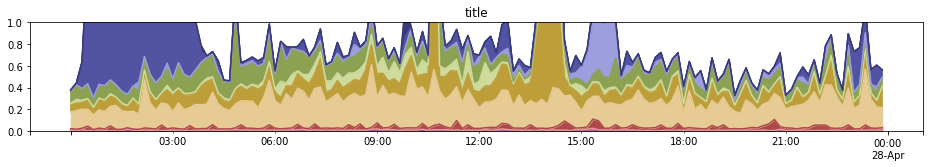

In [557]:
#df80 = df80.T
fig = plt.figure(figsize=(16,2), dpi=72)
ax = plt.subplot(111)
ax.set_ylim([0,1])
df80=df80.resample('10T').agg(np.average)
#df80.plot(kind='bar', width=1, stacked=True, colormap='tab20b_r', ax=ax, legend=False, title='title')
df80.plot(kind='area', stacked=True, colormap='tab20b_r', ax=ax, legend=False, title='title')

for n, label in enumerate(ax.get_xticklabels()):
    label.set_visible(n % 2 == 0)

plt.show()


In [558]:
df.size

115344

In [559]:
df0 = pd.DataFrame(ceilgroup(df,80).T.agg(np.average))
df0.style.bar()

,0
800,5.05604e-05
720,0.00103418
640,0.00855302
560,0.0279269
480,0.252427
400,0.157166
320,0.0463449
240,0.133429
160,0.0430935
80,0.219012


In [455]:
%%time

div = 40

nidx = np.arange(800,-div,-div)
series = []
for n,idx in enumerate(nidx):
    if idx == 0:
        s = df[df.index == 0].sum()
    else:
        s = df[np.logical_and(df.index <= idx, nidx[n+1] < df.index)].sum()
    series.append(s)    
df0 = pd.DataFrame(series, index=nidx) 

        
#     0 in pd.Interval(left=0, right=0, closed='both')
#     df.index in pd.Interval(left=0, right=0, closed='both')
#df[pd.cut(df.index, np.arange(0,801,40))[1]]


CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.1 ms


In [435]:
div=80
bins = pd.Int64Index(np.arange(800,-div,-div))
bins

Int64Index([800, 720, 640, 560, 480, 400, 320, 240, 160, 80, 0], dtype='int64')

In [383]:
np.digitize(df.index, bins)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [394]:
pd.

array([11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8